<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/Frame_interpolation_using_FILM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Frame interpolation using FILM model

In [3]:
!pip install -q mediapy --quiet

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import requests
import numpy as np
from typing import Generator, Iterable, List, Optional
from PIL import Image
import mediapy as media

In [5]:
model = hub.load('https://tfhub.dev/google/film/1')

In [7]:
def load_image(filename):
  UINT8_MAX_F = float(np.iinfo(np.uint8).max)
  img = Image.open(filename).convert('RGB')
  img_numpy = tf.cast(np.array(img), dtype=tf.float32).numpy()
  return img_numpy / UINT8_MAX_F

time = np.array([0.5], dtype=np.float32)
img1 = load_image('/content/istockphoto-1376910288-612x612.jpg')
img2 = load_image('/content/istockphoto-972902038-612x612.jpg')

In [8]:
input = {
    'time': np.expand_dims(time, axis=0),
    'x0': np.expand_dims(img1, axis=0),
    'x1': np.expand_dims(img2, axis=0)
}
mid_frame = model(input)

First input image,Generated image,Second input image

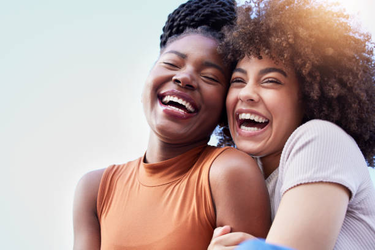
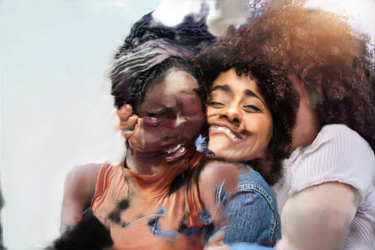
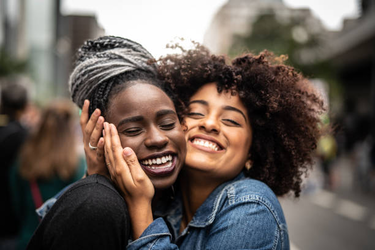

In [9]:
frames = [img1, mid_frame['image'][0].numpy(), img2]

media.show_images(frames, titles=['First input image', 'Generated image', 'Second input image'],
                  height=250)

In [10]:
media.show_video(frames, fps=3, title='FILM interpolated video', height=250)

##Frame interpolator

In [11]:
def pad_to_align(x, align):
  assert np.ndim(x) == 4
  assert align > 0

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
    'offset_height': height_to_pad // 2,
    'offset_width': width_to_pad // 2,
    'target_height': height + height_to_pad,
    'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
    'offset_height': height_to_pad // 2,
    'offset_width': width_to_pad // 2,
    'target_height': height,
    'target_width': width
  }
  return padded_x, bbox_to_crop

class Interpolator:
  def __init__(self, align: int = 64) -> None:
    self.model = hub.load('https://tfhub.dev/google/film/1')
    self.align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    if self.align is not None:
      x0, bbox_to_crop = pad_to_align(x0, self.align)
      x1, _ = pad_to_align(x1, self.align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self.model(inputs, training=False)
    img = result['image']
    if self.align is not None:
      img = tf.image.crop_to_bounding_box(img, **bbox_to_crop)

    return img.numpy()

##Frame and video generation utilities

In [12]:
def recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:

  if num_recursions == 0:
    yield frame1
  else:
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from recursive_generator(frame1, mid_frame, num_recursions - 1,
                                   interpolator)
    yield from recursive_generator(mid_frame, frame2, num_recursions - 1,
                                   interpolator)

def interp_recursively(frames: List[np.ndarray], num_recursions: int,
                       interpolator: Interpolator) -> Iterable[np.ndarray]:
  n = len(frames)
  for i in range(1, n):
    yield from recursive_generator(frames[i - 1], frames[i], times_to_interp,
                                   interpolator)
  yield frames[-1]

times_to_interp = 6
interpolator = Interpolator()

##Running the interpolator

In [13]:
input_frames = [img1, img2]
frames = list(interp_recursively(input_frames, times_to_interp, interpolator))
print(f'Video with {len(frames)} frames')
media.show_video(frames, fps=30, title='FILM interpolated video')

Video with 65 frames
